In [1]:
import os, shutil
import flopy as fp
import numpy as np
from IPython.display import Image
import pyemu
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Quick check for Windows to make sure input files are Windows type
import platform
if 'window' in platform.platform().lower():
    newln='\n'
else:
    newln='\r\n'

setting random seed


In [2]:
base_dir = os.path.join('..','..','models','Freyberg','Freyberg_zones')
[shutil.copy2(os.path.join(base_dir,cf),cf) for cf in os.listdir(base_dir)];

# Set up pilot points network for Freyberg model

There are multiple approaches to implementing pilot points with PEST++.  

In this class, we will use a st of tools provided with PEST.

## First we need a simple file called `settings.fig`

This sets up a couple preferences that reflect the region of the world that project data is from (e.g. US or elsewhere)

In [3]:
with open('settings.fig', 'w') as ofp:
    ofp.write('colrow=no{0}'.format(newln))
    ofp.write('date=mm/dd/yyyy{0}'.format(newln))

### Next we need a `model.spc` file - we will name it `freyberg.spc` 

This orients the model to the world using the convention outlined in the _PEST Groundwater Data Utilities Part A: Overview_ pages 13-15:

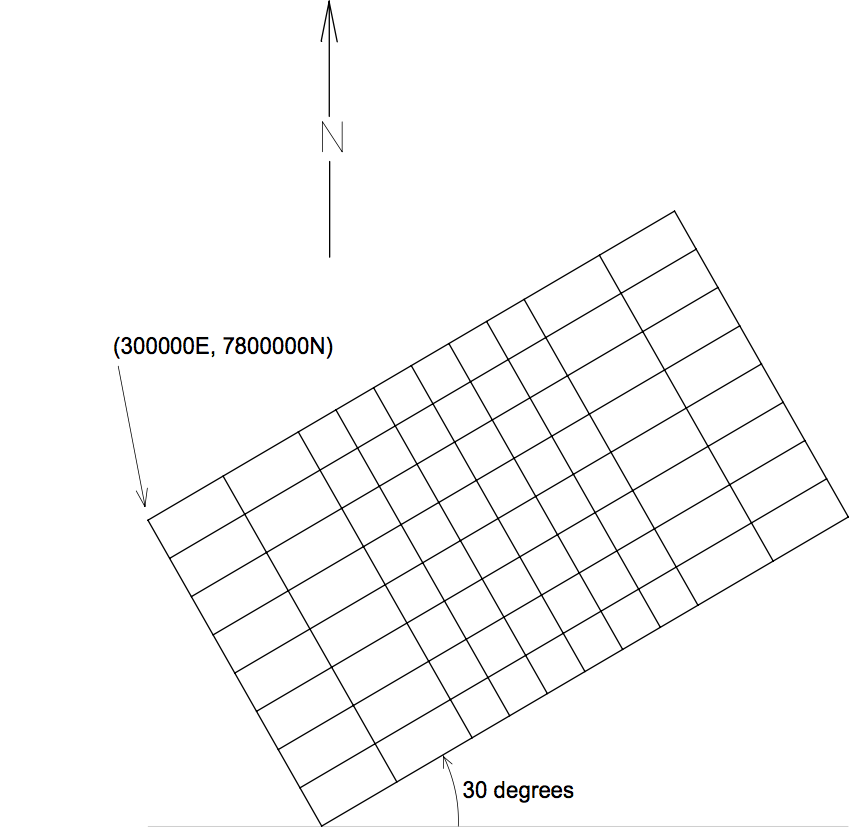

In [4]:
Image(filename=os.path.join('images','model.spc.png'),width=500)

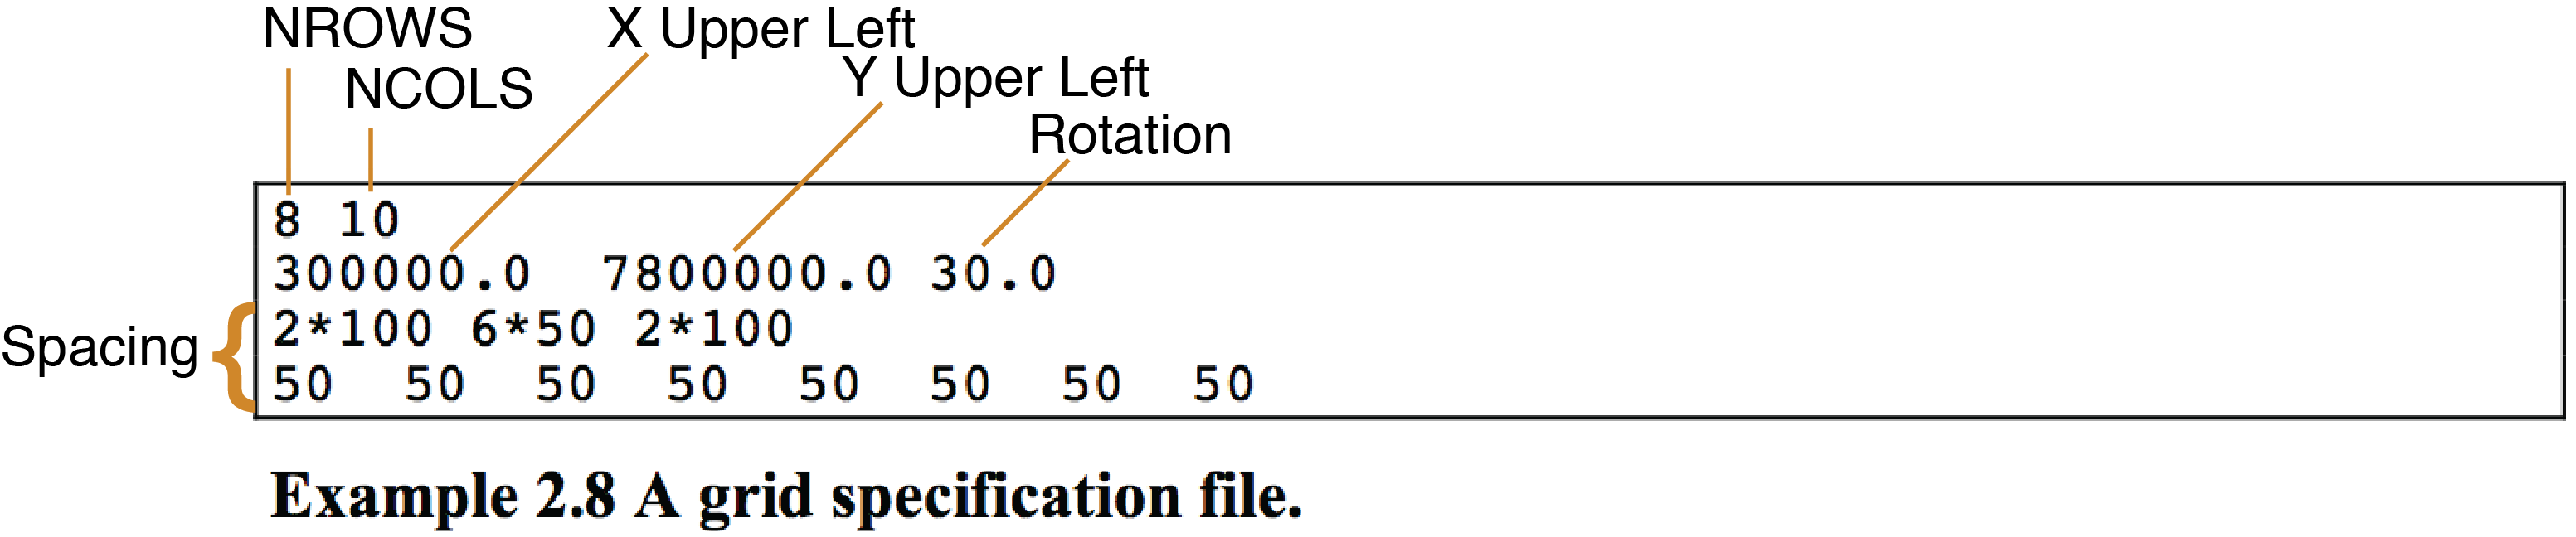

In [5]:
Image(filename=os.path.join('images','model_spc_txt.png'),width=600)

### We need to make one for our model

We could read the information from the DIS file or we could use `flopy` to read it in automagically

In [6]:
inmod = fp.modflow.Modflow.load('freyberg_zones.nam')
inmod.ncol

20

In [7]:
inmod.dis.delr.array

array([ 250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.,
        250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.,
        250.,  250.], dtype=float32)

In [8]:
np.sum(inmod.dis.delc.array)

10000.0

In [9]:
with open('freyberg.spc','w') as ofp:
    # first write NROWS and NCOLS
    ofp.write('{0} {1}{2}'.format(inmod.nrow,inmod.ncol,newln))
    # If we assume the lower left corner is 0,0, then the upper left corner
    # is 0, sum(delc)
    # we also need the rotation angle (0.0)
    ofp.write('{0:.4f} {1:.4f} {2:.4f}{3}'.format(0,np.sum(inmod.dis.delc.array),0,newln))
    # Finally we need to row and column spacings
    [ofp.write('{0:.4f} '.format(i)) for i in inmod.dis.delr.array]
    ofp.write(newln)
    [ofp.write('{0:.4f} '.format(i)) for i in inmod.dis.delc.array]
    ofp.write(newln)
    

## Set up zones for where pilot points will be interpolated

We can have pilot point networks in multiple zones. In this case, we will make a simple zone file using `IBOUND` such that all active cells are in the same interpolation zone.

### Read in IBOUND and take a quick look at it

In [10]:
ib = np.loadtxt('ibound.ref', dtype=int)

# or could read from flopy
ib= inmod.bas6.ibound.array[0,:,:].astype(int) #(we only want layer 0)

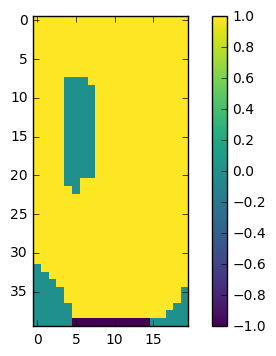

In [11]:
plt.imshow(ib, interpolation='nearest',cmap='viridis')
plt.colorbar();

### We don't want pilot points or care about HK values in inactive cells, but we do need values in constant heads

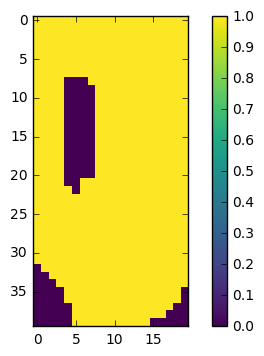

In [12]:
ppzones = ib.copy()
ppzones[ppzones !=0] = 1
plt.imshow(ppzones, interpolation='nearest',cmap='viridis')
plt.colorbar();

### let's save this down as "`HK.zones`"

In [13]:
np.savetxt('HK.zones',ppzones, fmt='%d')

## Now we need to set locations for the pilot points
Our strategy is to put a point in every third cell on a grid. Of course, we don't want pilot points in the inactive cells, though, so we can set up a network, censor it removing inactive cells, and then build the other dependencies we need.

Note that pilot points need to be defined in real-world coordinates so we need top navigate between rows/columns and x/y locations.

### `flopy` has a handy function to return the x and y locations of the cell centers. We also need an array each for rows and columns

In [14]:
# cell centers in x and y
x_centers = inmod.sr.get_xcenter_array()
y_centers = inmod.sr.get_ycenter_array()
# vectors of rows and columns
rows= np.arange(inmod.nrow)
cols = np.arange(inmod.ncol)

In [15]:
row_locations = rows[2::3]
col_locations = cols[2::3]

In [16]:
row_locations 

array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38])

## We can loop first over rows, then over columns to make a grid

In [17]:
allcol = []
allrow = []
for cr in row_locations:
    for cc in col_locations:
        allrow.append(cr)
        allcol.append(cc)

### Let's take a quick look at the results

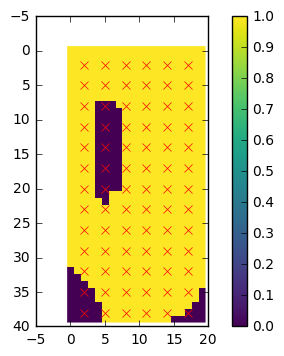

In [18]:
plt.imshow(ppzones, interpolation='nearest', cmap='viridis')
plt.plot(allcol,allrow,'rx')
plt.colorbar();

### Not bad, but we need to censor to get rid of the pilot points in inactive cells

In [19]:
keeprow = []
keepcol = []
for cr,cc in zip(allrow,allcol):
    if ppzones[cr,cc] == 1:
        keeprow.append(cr)
        keepcol.append(cc)
# convert from row/columns to x/y        
keepx = [x_centers[i] for i in keepcol]
keepy = [y_centers[i] for i in keeprow]


### Let's look again

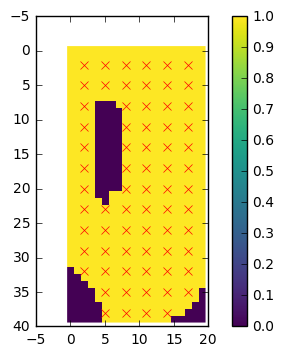

In [20]:
plt.imshow(ppzones, interpolation='nearest', cmap='viridis')
plt.plot(keepcol,keeprow,'rx')
plt.colorbar();

# We now need both a pilot points file and a `template` file that will write it

In [21]:
# set default layer (clay) 
clay = 1
# set default starting value for HK
hk_start = 5.5

# open a TPL file for writing
with open('points1.dat.tpl', 'w') as ofptpl:
    # also open a points1.dat file for writing
    with open('points1.dat', 'w') as ofpdat:
        ofptpl.write('ptf ~{0}'.format(newln))
        for i,(cx,cy) in enumerate(zip(keepx,keepy)):
            cppval = 'hkpp{0}'.format(i+1)
            ofptpl.write('{0:12} {1:12.4f} {2:12.4f} {3:d} ~{4:^16}~{5}'.format(cppval,
                                                                             cx,
                                                                              cy,
                                                                              clay,
                                                                             cppval,
                                                                              newln))
            ofpdat.write('{0:12} {1:12.4f} {2:12.4f} {3:d} {4:18.5e}{5}'.format(cppval,
                                                                             cx,
                                                                              cy,
                                                                              clay,
                                                                             hk_start,
                                                                          newln))


## Need to create Kriging factors and regularization inputs
Following the guidelines in _Approaches to Highly Parameterized Inversion: Pilot-Point Theory, Guidelines, and Research Directions_ https://pubs.usgs.gov/sir/2010/5168/

### First we need to define a couple geostatistical structures (e.g. variograms)

From _PEST Groundwater Data Utilities Part A: Overview_ page 43, there are 4 acceptable variogram types:

 1. *Spherical*  
### $\gamma\left(h\right)=c\times\left[1.5\frac{h}{a}-0.5\frac{h}{a}^3\right]$ if $h<a$
### $\gamma\left(h\right)=c$ if $h \ge a$  
     
 2. *Exponential*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h}{a}\right)\right]$  
     
 3. *Gaussian*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h^2}{a^2}\right)\right]$  
 
 4. *Power*  
### $\gamma\left(h\right)=c\times h^a$
     
 The number refers to `VARTYPE`. `BEARING` and `ANISOTROPY` only apply if there is a principal direction of anisotropy. $h$ is the separation distance, and $a$ is the range, expressed with the `A` parameter.


In [22]:
# So we can make a single variogram in our structure, exponential with range of 1500

with open('struct.dat', 'w') as ofp:
    ofp.write('STRUCTURE struct1{0}'.format(newln))
    ofp.write('   NUGGET 0.000000{0}'.format(newln))
    ofp.write('   TRANSFORM log{0}'.format(newln))
    ofp.write('   MEAN 0.000000{0}'.format(newln))
    ofp.write('   NUMVARIOGRAM 1{0}'.format(newln))
    ofp.write('   VARIOGRAM var1 1.000000{0}'.format(newln))
    ofp.write('END STRUCTURE{0}{0}'.format(newln))
    ofp.write('VARIOGRAM var1{0}'.format(newln))
    ofp.write('   VARTYPE 2{0}'.format(newln))
    ofp.write('   BEARING 0.000000{0}'.format(newln))
    ofp.write('   A 1500.00{0}'.format(newln))
    ofp.write('   ANISOTROPY 1.0000{0}'.format(newln))
    ofp.write('END VARIOGRAM{0}'.format(newln))
    
      



## Now we can make a response file for `ppk2fac.exe` which creates the Kriging factors and also regularization information we will need later.

In [23]:
with open('ppk2fac.in', 'w') as ofp:
    ofp.write('freyberg.spc{0}'.format(newln))
    ofp.write('points1.dat{0}'.format(newln))
    ofp.write('0.0{0}'.format(newln))
    ofp.write('lay1zones.dat{0}'.format(newln))
    ofp.write('f{0}'.format(newln))
    ofp.write('struct.dat{0}'.format(newln))
    ofp.write('struct1{0}'.format(newln))
    ofp.write('o{0}'.format(newln))
    ofp.write('1500.0{0}'.format(newln))
    ofp.write('1{0}'.format(newln))
    ofp.write('8{0}'.format(newln))
    ofp.write('factors1.dat{0}'.format(newln))
    ofp.write('f{0}'.format(newln))
    ofp.write('stddev1.ref{0}'.format(newln))
    ofp.write('reg1.dat{0}'.format(newln))

### Now run `ppk2fac <ppk2fac.in`

## For `ppkreg.exe` we need a response file (like we did for `ppk2fac`)

In [24]:
with open('ppkreg.in', 'w') as ofp:
    ofp.write('freyberg_pp.pst{0}'.format(newln))
    ofp.write('reg1.dat{0}'.format(newln))
    ofp.write('1{0}'.format(newln))
    ofp.write('{0}'.format(newln))
    ofp.write('g{0}'.format(newln))
    ofp.write('1.0{0}'.format(newln))
    ofp.write('regulhkpp{0}'.format(newln))
    ofp.write('ihkpp{0}'.format(newln))
    ofp.write('y{0}'.format(newln))
    ofp.write('freyberg_pp_reg.pst{0}'.format(newln))
    ofp.write('25{0}'.format(newln))
    ofp.write('1.0{0}'.format(newln))
    ofp.write('{0}'.format(newln))
    ofp.write('{0}'.format(newln))

### Now run `ppkreg <ppkreg.in`

##  Each time we run `fac2real` we need a response file as well

*NOTE* This can be replaced with a tool in `pyemu` as well

In [25]:
with open('fac2real1.in', 'w') as ofp:
    ofp.write('factors1.dat{0}'.format(newln))
    ofp.write('f{0}'.format(newln))
    ofp.write('points1.dat{0}'.format(newln))
    ofp.write('s{0}'.format(newln))
    ofp.write('1e-6{0}'.format(newln))
    ofp.write('s{0}'.format(newln))
    ofp.write('1e6{0}'.format(newln))
    ofp.write('hk.ref{0}'.format(newln))
    ofp.write('1e35{0}'.format(newln))

## Finally(!) we need to update a `PEST` control file and the model run script

## First the control file. We can read in the `freyberg_zones.pst` file and make a few changes

We can either make changes in a text editor or using `pyemu`

In [26]:
inpst = pyemu.Pst('freyberg_zones.pst')

In [27]:
# get rid of the zoned HK parameters and make sure rch1 is log-transformed
inpst.parameter_data.drop(['hk{0}'.format(i) for i in range(1,7)], inplace=True)
inpst.parameter_data.loc[inpst.parameter_data.parnme=='rch1', 'partrans'] = 'log'
inpst.parameter_data.loc[inpst.parameter_data.parnme=='rch1', 'parval1'] = 1.1e-4


### next we need to populate a list of rows with values for each column

Note that we called the pilot points 'hkpp#' where '#' is a number from 1 to the number of pilot points. We can do the same here and give each one the same range and bounds

In [28]:
data=[]
for i in range(len(keepx)):
    cname = 'hkpp{0}'.format(i+1)
    data.append({'parnme':cname,
               'partrans': 'log',
               'parchglim': 'factor',
               'parval1':8.0,
               'parlbnd':1.25,
               'parubnd':80.0,
               'pargp':'pilotpt',
               'scale':1.0,
               'offset':0.0,
               'dercom':1})


In [29]:
# append that information into the parameter_data part of the pst file
inpst.parameter_data=inpst.parameter_data.append(pd.DataFrame(data)[inpst.parameter_data.columns])

In [30]:
inpst.input_files

['freyberg.rch', 'hk.ref']

In [31]:
# change the TPL file to be writing points1.dat rather than hk.ref
inpst.template_files = ['points1.dat.tpl','freyberg.rch.tpl']
inpst.input_files = ['points1.dat','freyberg.rch']


In [32]:
# change the model_command to be a new script we will write below
inpst.model_command=['python run_model_pp.py']

In [33]:
# finally, write out the file
inpst.write('freyberg_pp.pst')

['pilotpt']


### let's look at `run_model.py` ... we will need to add in the pilot point interpolation step

In [34]:
inlines = open('run_model.py', 'r').readlines()
for line in inlines:
    print(line.strip())

import os
import platform
if 'window' in platform.platform().lower():
pref = ''
else:
pref = './'
os.system("{0}mf2005 freyberg_zones.nam".format(pref))
os.system("{0}mp6 <mpath.in".format(pref))
os.system("python Process_output.py")


In [35]:
with open('run_model_pp.py', 'w') as ofp:
    ofp.write('import pyemu, os{0}'.format(newln))
    ofp.write('pyemu.utils.gw_utils.fac2real("points1.dat","factors1.dat","hk.ref",lower_lim=1.0e-10){0}'.format(newln))
    for line in inlines[1:]:
        ofp.write('{0}{1}'.format(line.strip(),newln))